In [1]:
import warnings;
warnings.filterwarnings('ignore');
import pandas as pd
import sklearn
import numpy as np
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('statsandsal_cleaned.csv')

Create dummy columns for the one categorical variable: Position

In [3]:
df = pd.get_dummies(df)

Split into train/test

In [4]:
from sklearn.model_selection import train_test_split
X = df.drop('Salary', axis=1)
y = df.Salary.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Now standardize the salary in y_train so that all are on a salary cap of $100,000,000 (See Data_PreProcessing notebook for explanation)

In [5]:
# Divide 100 by the salary cap of that year to get 
# standardizaton factor
caps = {
2012: 100/58.044000,	
2013: 100/58.044000,	
2014: 100/58.679000,	
2015: 100/63.065000,	
2016: 100/70.000000,	
2017: 100/94.143000,	
2018: 100/99.093000,	
2019: 100/101.869000,	
2020: 100/109.140000	
        }
# Create temporary dataframe to map factors to y_train
yvals = list(pd.Series(y_train).values)
dates = list(X_train['Date'].values)
temp = pd.DataFrame({'Salary':yvals,'Date':dates})
temp['Factor'] = temp['Date'].map(caps)
temp['Salary'] = temp['Salary'] * temp['Factor']
y_train = np.array(temp['Salary'])

# 1. Linear Regression

We will perform linear regression using two packages:
- Statsmodels to evaluate model coefficients
- Sklearn for predictions

We will use mean absolute error as our performance metric throughout as it is intuitive to interpret

### 1.1 Statsmodels Regression

In [18]:
import statsmodels.api as sm
X_sm  = sm.add_constant(X)
model = sm.OLS(y,X_sm)
results = model.fit().summary()
print(results)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     97.46
Date:                Mon, 21 Dec 2020   Prob (F-statistic):               0.00
Time:                        17:22:53   Log-Likelihood:                -11442.
No. Observations:                3990   AIC:                         2.299e+04
Df Residuals:                    3937   BIC:                         2.332e+04
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -576.1661     58.477     -9.853      0.0

- The current model explains 56.3% of the variance in player salary
- There is significant multicollinearity as expected, so it is difficult to assess feature importance


Check multicollinearity using VIF:

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

vif = calc_vif(X) 
vif

,variables,VIF
0,Age,1.174151
1,G,11.535912
2,GS,4.784511
3,MP,45.929810
4,FG,4854.431688
5,FGA,9598.688488
6,FG%,188.657369
7,3P,495.928222
8,3PA,1860.451967
9,3P%,2.501490


Since our objective is prediction, we will not drop these correlated features

### 1.2 Scikit-learn Regression

Run the model using the training data and evaluate results using 5-fold cross-validation

In [7]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score
lm = LinearRegression()
lm.fit(X_train,y_train)
lm_res = cross_val_score(lm, X_train, y_train, scoring = 'neg_mean_absolute_error',cv=5)
print(lm_res)
print(np.mean(lm_res))

[-3.79134998 -3.83789897 -3.84999837 -3.68338861 -3.69803466]
-3.772134117306016


# 2. Lasso Regression

Lasso regression is used for L1 regularization and it will shrink the coefficients of unimportant features to 0. We first build the model using the default parameters and then tune the alpha hyperparameter which multiplies the L1 term

In [8]:
from sklearn.linear_model import Lasso
lm_l = Lasso()
lm_l.fit(X_train,y_train)
lml_base_res = cross_val_score(lm_l, X_train, y_train, scoring = 'neg_mean_absolute_error',cv=5)
print(lml_base_res)
print(np.mean(lml_base_res))

[-3.92607305 -3.9454999  -3.91099838 -3.84958445 -3.87178944]
-3.9007890434047896


Now tune the alpha parameter:

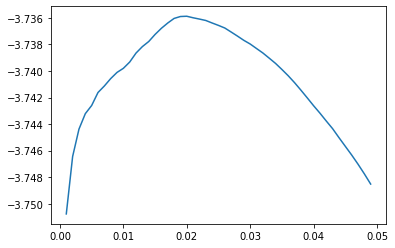

In [22]:
alpha = []
error = []

for i in range(1,50):
    alpha.append(i/1000)
    lml = Lasso(alpha=(i/1000))
    error.append(np.mean(cross_val_score(lml, X_train, y_train, scoring = 'neg_mean_absolute_error',cv=5)))

plt.plot(alpha,error)
err = list(zip(alpha,error))
from operator import itemgetter
err = sorted(err,key=itemgetter(1))[-1]
best_alpha = err[0]

In [23]:
best_alpha

0.02

Now we fit and cross-validate the model using the given value for alpha

In [26]:
lm_l = Lasso(alpha=best_alpha)
lm_l.fit(X_train,y_train)
lasso_res = cross_val_score(lm_l, X_train, y_train, scoring = 'neg_mean_absolute_error',cv=5)
print(lasso_res)
print(np.mean(lasso_res))

[-3.76186039 -3.82433762 -3.82287457 -3.62039539 -3.64992141]
-3.7358778743455914


This is a slight improvement compared to our base lasso and linear regression

# 3. Random Forest Regression

We will follow the same procedure as the previous model:
1. Fit a model with only default parameters 
2. Tune the model using cross-validation 
3. Fit the final model with tuned parameters

In [27]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_scores = cross_val_score(rf, X_train, y_train,scoring = 'neg_mean_absolute_error',cv=5)
print(rf_scores)
print(np.mean(rf_scores))

[-3.10018956 -3.34563122 -3.24240945 -3.17474812 -3.14141951]
-3.2008795746443055


This already outperforms the previous models

We will now tune the model using a RandomizedSearch, which was chosen over GridSearch since it yielded similar performance with less computational time

In [28]:
from sklearn.model_selection import RandomizedSearchCV
rf_hyperparameters = {
        'n_estimators': [120,150,180],
        'max_depth': [3,5,10],
        'min_samples_split': [3,5,7],
        'min_samples_leaf':[5,8,11],
        'max_features': ['auto','sqrt'],
        }
random_cv_rf = RandomizedSearchCV(estimator=rf,
            param_distributions=rf_hyperparameters,
            cv=5, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs=-1,
            verbose=5,
            return_train_score = True,
            random_state=42
        )
random_cv_rf.fit(X_train,y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  2.8min finished


In [29]:
best_rf = random_cv_rf.best_estimator_
print(best_rf)

RandomForestRegressor(max_depth=10, min_samples_leaf=5, min_samples_split=3,
                      n_estimators=150)


In [30]:
rf_tuned_scores = cross_val_score(best_rf, X_train, y_train, scoring = 'neg_mean_absolute_error',cv=5)
print(rf_tuned_scores)
print(np.mean(rf_tuned_scores))

[-3.06210197 -3.31434088 -3.20004481 -3.15168383 -3.08008535]
-3.1616513679428677


# 4. XGBoost Regressor

XGBoost (Extreme Gradient Boosting) is likely the most popular predictive algorithm for structured data at the moment. The procedure for XGBoost will be the same as the previous two.

In [31]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_train,y_train)
xgb_res = cross_val_score(xgb, X_train, y_train, scoring = 'neg_mean_absolute_error',cv=5)
print(xgb_res)
print(np.mean(xgb_res))

[-3.2867294  -3.48275902 -3.37105822 -3.30147888 -3.35968413]
-3.3603419308099136


In [33]:
xgb_hyperparameters = {
        'n_estimators': [50, 75, 100],
        'max_depth': [2, 5, 10],
        'learning_rate': [0.01, 0.03, 0.05],
        'min_child_weight':[0.4, 0.7, 1],
        'booster': ['gbtree','gblinear'],
        'base_score': [0.75, 1, 1.25]
        }

random_cv_xgb = RandomizedSearchCV(estimator=xgb,
            param_distributions=xgb_hyperparameters,
            cv=5, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs=-1,
            verbose=5,
            return_train_score = True,
            random_state=42
        )
random_cv_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   59.0s finished


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          gpu_id=-1, importance_type='gain',
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_delta_step=0, max_depth=6,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=100, n_jobs=4,
                                          num_par...
                                          tree_method='exact',
                                          validate_parameters=1,
                   

In [34]:
best_xgb = random_cv_xgb.best_estimator_
xgb_tuned_res = cross_val_score(best_xgb, X_train, y_train, scoring = 'neg_mean_absolute_error',cv=5)
print(xgb_tuned_res)
print(np.mean(xgb_tuned_res))

[-3.06321123 -3.31307183 -3.19989155 -3.0590898  -3.0894286 ]
-3.1449386016428234


The results from cross-validation are very similar to random forest, with a slightly better average error.

# 5. Making predictions on the test set

In [35]:
pred_lm = lm.predict(X_test)
pred_lml = lm_l.predict(X_test)
pred_rf_base = rf.predict(X_test)
pred_rf_tuned = best_rf.predict(X_test)
pred_xgb_base = xgb.predict(X_test)
pred_xgb_tuned = best_xgb.predict(X_test)

To evaluate the results, we will use mean absolute error. We will also divide the predicted values by the associated salary cap factor for that year which we used earlier. This will ensure our predictions will be in the same reference as the unaltered test data.

In [36]:
from sklearn.metrics import mean_absolute_error
# Add the factor column back
X_test['Factor'] = X_test['Date'].map(caps)
# Fine mean absolute error of the predicted values divided by the factor
lm_results = mean_absolute_error(pred_lm/X_test['Factor'],y_test)
lml_results = mean_absolute_error(pred_lml/X_test['Factor'],y_test)
rf_base_results = mean_absolute_error(pred_rf_base/X_test['Factor'],y_test)
rf_tuned_results = mean_absolute_error(pred_rf_tuned/X_test['Factor'],y_test)
xgb_base_results = mean_absolute_error(pred_xgb_base/X_test['Factor'],y_test)
xgb_tuned_results = mean_absolute_error(pred_xgb_tuned/X_test['Factor'],y_test)

In [38]:
results_all = pd.DataFrame({'Model':['Linear Regression','Lasso Regression','Random Forest Base','Random Forest Tuned','XGBoost Base','XGBoost Tuned'],
                'Mean Absolute Error (In millions of $)': [lm_results, lml_results,rf_base_results,rf_tuned_results,xgb_base_results,xgb_tuned_results]})
results_all 

,Model,Mean Absolute Error (In millions of $)
0,Linear Regression,3.015034
1,Lasso Regression,2.997216
2,Random Forest Base,2.609782
3,Random Forest Tuned,2.608315
4,XGBoost Base,2.674901
5,XGBoost Tuned,2.612677


The best model was the tuned Random Forest, with a mean absolute error equal to $2.6 million. The tuned XGBoost performed very similarly and both significantly outperformed the base regression models.